# Model Application

## 1. Importing Libraries

- Importing the necessary libraries to deal with the data. We are going to need **NumPy**, **Pandas** and **Pathlib** to import the data. The **Tensorflow** library is going to be used to apply the model and to plot the data, we are going to use **Matplotlib** and **Seaborn**.

In [1]:
# Libraries to deal with the data
import numpy as np
import pandas as pd
import os
import tempfile
import pathlib
import random

# Libraries to work neural networks
import tensorflow as tf
from tensorflow import keras

# Libraries to plot the results
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 2. Importing Preprocessed Data

- Defining the **file parameters** to import the preprocessed data.

In [3]:
# File parameters

path = str(pathlib.Path().absolute())
path_dataset = path + '\\Datasets\\'
path_figures = path + '\\Figures\\'
path_result = path + '\\Result\\'

- Importing the preprocessed **down-sampled 50/50** dataset.

In [4]:
# Train dataset
npz_ds = np.load(path_result + 'DS_5050_backorder_data_train.npz')

train_inputs_ds_5050 = npz_ds['inputs'].astype(np.float)
train_targets_ds_5050 = npz_ds['targets'].astype(np.int)

# Validation dataset
npz_ds = np.load(path_result + 'DS_5050_backorder_data_validation.npz')

validation_inputs_ds_5050 = npz_ds['inputs'].astype(np.float)
validation_targets_ds_5050 = npz_ds['targets'].astype(np.int)

# Single test dataset
npz_ds = np.load(path_result + 'DS_5050_backorder_data_test.npz')

test_inputs_ds_5050 = npz_ds['inputs'].astype(np.float)
test_targets_ds_5050 = npz_ds['targets'].astype(np.int)

- Importing the preprocessed **down-sampled 05/95** dataset.

In [5]:
# Train dataset
npz_ds = np.load(path_result + 'DS_0595_backorder_data_train.npz')

train_inputs_ds_0595 = npz_ds['inputs'].astype(np.float)
train_targets_ds_0595 = npz_ds['targets'].astype(np.int)

# Validation dataset
npz_ds = np.load(path_result + 'DS_0595_backorder_data_validation.npz')

validation_inputs_ds_0595 = npz_ds['inputs'].astype(np.float)
validation_targets_ds_0595 = npz_ds['targets'].astype(np.int)

# Single test dataset
npz_ds = np.load(path_result + 'DS_0595_backorder_data_test.npz')

test_inputs_ds_0595 = npz_ds['inputs'].astype(np.float)
test_targets_ds_0595 = npz_ds['targets'].astype(np.int)

- Importing the preprocessed **up-sampled** dataset.

In [6]:
# Train dataset
npz_us = np.load(path_result + 'US_backorder_data_train.npz')

train_inputs_us = npz_us['inputs'].astype(np.float)
train_targets_us = npz_us['targets'].astype(np.int)

# Validation dataset
npz_us = np.load(path_result + 'US_backorder_data_validation.npz')

validation_inputs_us = npz_us['inputs'].astype(np.float)
validation_targets_us = npz_us['targets'].astype(np.int)

# Single test dataset
npz_us = np.load(path_result + 'US_backorder_data_test.npz')

test_inputs_us = npz_us['inputs'].astype(np.float)
test_targets_us = npz_us['targets'].astype(np.int)

- Reimporting the **test_for_all** dataset.

In [7]:
# Test for all dataset will be evaluated by all trained models. 
# This dataset was separated before the preprocessing phase.

npz_tfa = np.load(path_result + 'TFA_backorder_data_gral_test.npz')

test_inputs_tfa = npz_tfa['inputs'].astype(np.float)
test_targets_tfa = npz_tfa['targets'].astype(np.int)

## 3. Defining Model

- Defining **hyperparameters** for the model. These parameters are going to be used by all trained models.

In [8]:
# Number of features
input_size = 29

# Number of targets
# output_size = 2 # Softmax activation function
output_size = 1 # Sigmoid activation function

# Size of Hidden Layers
hidden_layer_size = 15
hidden_layer_size_2 = 15

- Defining the ANN model to train using the 3 sampled datasets (**Down-sampled 50/50**, **Down-sampled 05/95** and **Upsampled**).

In [9]:
# Defining the Sequential model with 2 Hidden layers.
# Using "relu" activation funtion of Hidden layers.
# Using "sigmoid" activation function for output layer.

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          hidden_layer_size, activation='relu',
          input_shape=(train_inputs_ds_0595.shape[-1],)),  # all datasets have the same number of inputs
      keras.layers.Dense(
          hidden_layer_size_2, activation='relu'),
      # keras.layers.Dropout(0.5),
      keras.layers.Dense(output_size, activation='sigmoid',
                         bias_initializer=output_bias),
  ])


# Defining the optimizer and the loss-function for the model.

# Using ADAM which is an enhancement of Stocatic Gradient Descendent (SGD).
# Using metrics relevant for this kind of classification problems

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model


- Defining **hyperparameters** to fit the models with train data.

In [10]:
# set the batch size, but we might not need this
BATCH_SIZE = 4000


# set a maximum number of training epochs
EPOCHS = 150

- Applying a early stopping mechanism to avoid **overfitting** of the model.

In [11]:
# Set an early stopping mechanism
# Set patience=10, to be a bit tolerant against random validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [12]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                450       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 706
Trainable params: 706
Non-trainable params: 0
_________________________________________________________________


## 4. Training and Testing Model 

- Training the model using the **down-sampled 50/50** dataset.

In [13]:
model = make_model()
baseline_history = model.fit(
    train_inputs_ds_5050,  # train inputs
    train_targets_ds_5050, # train targets
    # batch_size=BATCH_SIZE, # batch size
    epochs=EPOCHS,         # epochs that we will train for (assuming early stopping doesn't kick in)
    callbacks = [early_stopping],  # early stopping
    validation_data=(validation_inputs_ds_5050, validation_targets_ds_5050) # validation data
)




Epoch 1/150
400/400 [==============================] - 3s 7ms/step - loss: 0.6480 - tp: 3424.0000 - fp: 1609.0000 - tn: 4717.0000 - fn: 3050.0000 - accuracy: 0.6360 - precision: 0.6803 - recall: 0.5289 - auc: 0.6902 - val_loss: 0.6278 - val_tp: 515.0000 - val_fp: 300.0000 - val_tn: 543.0000 - val_fn: 242.0000 - val_accuracy: 0.6612 - val_precision: 0.6319 - val_recall: 0.6803 - val_auc: 0.7105
Epoch 2/150
400/400 [==============================] - 1s 3ms/step - loss: 0.6111 - tp: 4542.0000 - fp: 2169.0000 - tn: 4157.0000 - fn: 1932.0000 - accuracy: 0.6796 - precision: 0.6768 - recall: 0.7016 - auc: 0.7309 - val_loss: 0.6084 - val_tp: 510.0000 - val_fp: 254.0000 - val_tn: 589.0000 - val_fn: 247.0000 - val_accuracy: 0.6869 - val_precision: 0.6675 - val_recall: 0.6737 - val_auc: 0.7339
Epoch 3/150
400/400 [==============================] - 1s 3ms/step - loss: 0.5934 - tp: 4580.0000 - fp: 1992.0000 - tn: 4334.0000 - fn: 1894.0000 - accuracy: 0.6964 - precision: 0.6969 - recall: 0.7074 - au

Epoch 22/150
400/400 [==============================] - 1s 2ms/step - loss: 0.5321 - tp: 4843.0000 - fp: 1635.0000 - tn: 4691.0000 - fn: 1631.0000 - accuracy: 0.7448 - precision: 0.7476 - recall: 0.7481 - auc: 0.8117 - val_loss: 0.5733 - val_tp: 561.0000 - val_fp: 218.0000 - val_tn: 625.0000 - val_fn: 196.0000 - val_accuracy: 0.7412 - val_precision: 0.7202 - val_recall: 0.7411 - val_auc: 0.8039
Epoch 23/150
400/400 [==============================] - 1s 3ms/step - loss: 0.5313 - tp: 4856.0000 - fp: 1629.0000 - tn: 4697.0000 - fn: 1618.0000 - accuracy: 0.7463 - precision: 0.7488 - recall: 0.7501 - auc: 0.8120 - val_loss: 0.5731 - val_tp: 549.0000 - val_fp: 207.0000 - val_tn: 636.0000 - val_fn: 208.0000 - val_accuracy: 0.7406 - val_precision: 0.7262 - val_recall: 0.7252 - val_auc: 0.8006
Epoch 24/150
400/400 [==============================] - 1s 2ms/step - loss: 0.5284 - tp: 4842.0000 - fp: 1598.0000 - tn: 4728.0000 - fn: 1632.0000 - accuracy: 0.7477 - precision: 0.7519 - recall: 0.7479 -

Epoch 43/150
400/400 [==============================] - 1s 2ms/step - loss: 0.5081 - tp: 4985.0000 - fp: 1541.0000 - tn: 4785.0000 - fn: 1489.0000 - accuracy: 0.7633 - precision: 0.7639 - recall: 0.7700 - auc: 0.8300 - val_loss: 0.5505 - val_tp: 575.0000 - val_fp: 194.0000 - val_tn: 649.0000 - val_fn: 182.0000 - val_accuracy: 0.7650 - val_precision: 0.7477 - val_recall: 0.7596 - val_auc: 0.8186
Epoch 44/150
400/400 [==============================] - 1s 2ms/step - loss: 0.5063 - tp: 4947.0000 - fp: 1529.0000 - tn: 4797.0000 - fn: 1527.0000 - accuracy: 0.7613 - precision: 0.7639 - recall: 0.7641 - auc: 0.8315 - val_loss: 0.5565 - val_tp: 547.0000 - val_fp: 180.0000 - val_tn: 663.0000 - val_fn: 210.0000 - val_accuracy: 0.7563 - val_precision: 0.7524 - val_recall: 0.7226 - val_auc: 0.8188
Epoch 45/150
400/400 [==============================] - 1s 2ms/step - loss: 0.5066 - tp: 4941.0000 - fp: 1495.0000 - tn: 4831.0000 - fn: 1533.0000 - accuracy: 0.7634 - precision: 0.7677 - recall: 0.7632 -

Epoch 64/150
400/400 [==============================] - 1s 2ms/step - loss: 0.4896 - tp: 5005.0000 - fp: 1439.0000 - tn: 4887.0000 - fn: 1469.0000 - accuracy: 0.7728 - precision: 0.7767 - recall: 0.7731 - auc: 0.8446 - val_loss: 0.5284 - val_tp: 548.0000 - val_fp: 178.0000 - val_tn: 665.0000 - val_fn: 209.0000 - val_accuracy: 0.7581 - val_precision: 0.7548 - val_recall: 0.7239 - val_auc: 0.8291
Epoch 65/150
400/400 [==============================] - 1s 2ms/step - loss: 0.4923 - tp: 4991.0000 - fp: 1432.0000 - tn: 4894.0000 - fn: 1483.0000 - accuracy: 0.7723 - precision: 0.7771 - recall: 0.7709 - auc: 0.8421 - val_loss: 0.5215 - val_tp: 559.0000 - val_fp: 179.0000 - val_tn: 664.0000 - val_fn: 198.0000 - val_accuracy: 0.7644 - val_precision: 0.7575 - val_recall: 0.7384 - val_auc: 0.8333
Epoch 66/150
400/400 [==============================] - 1s 3ms/step - loss: 0.4900 - tp: 5001.0000 - fp: 1431.0000 - tn: 4895.0000 - fn: 1473.0000 - accuracy: 0.7731 - precision: 0.7775 - recall: 0.7725 -

Epoch 85/150
400/400 [==============================] - 1s 2ms/step - loss: 0.4785 - tp: 5011.0000 - fp: 1380.0000 - tn: 4946.0000 - fn: 1463.0000 - accuracy: 0.7779 - precision: 0.7841 - recall: 0.7740 - auc: 0.8518 - val_loss: 0.4967 - val_tp: 595.0000 - val_fp: 191.0000 - val_tn: 652.0000 - val_fn: 162.0000 - val_accuracy: 0.7794 - val_precision: 0.7570 - val_recall: 0.7860 - val_auc: 0.8476
Epoch 86/150
400/400 [==============================] - 1s 2ms/step - loss: 0.4768 - tp: 5067.0000 - fp: 1388.0000 - tn: 4938.0000 - fn: 1407.0000 - accuracy: 0.7816 - precision: 0.7850 - recall: 0.7827 - auc: 0.8534 - val_loss: 0.5100 - val_tp: 584.0000 - val_fp: 210.0000 - val_tn: 633.0000 - val_fn: 173.0000 - val_accuracy: 0.7606 - val_precision: 0.7355 - val_recall: 0.7715 - val_auc: 0.8380
Epoch 87/150
400/400 [==============================] - 1s 3ms/step - loss: 0.4776 - tp: 5032.0000 - fp: 1386.0000 - tn: 4940.0000 - fn: 1442.0000 - accuracy: 0.7791 - precision: 0.7840 - recall: 0.7773 -

- Check training history

In [14]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


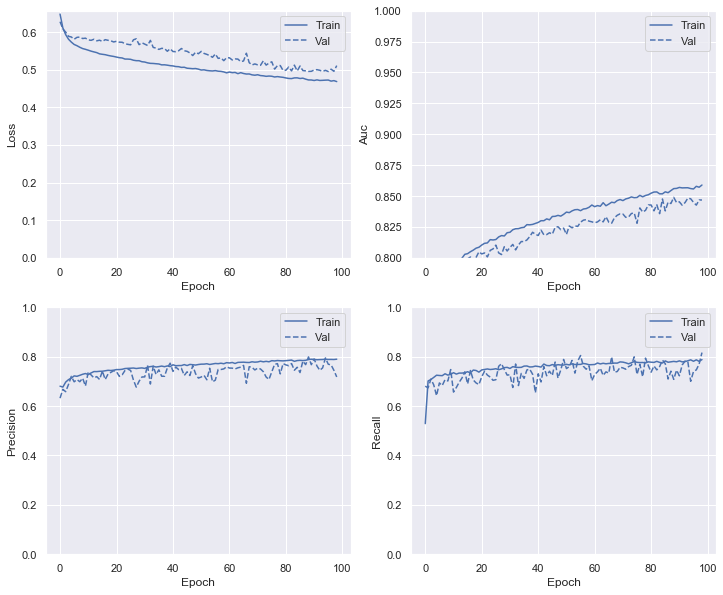

In [15]:
plot_metrics(baseline_history)

- Evaluating the **down-sampled 50/50** model using the **down-sampled 50/50** test dataset.

In [16]:
test_loss_ds_5050, test_tp_5050, test_fp_5050, test_tn_5050, test_fn_5050, test_accuracy_ds_5050, test_precision_5050, test_recall_5050, test_auc_5050 = model.evaluate(test_inputs_ds_5050, test_targets_ds_5050)

51/51 [==============================] - 0s 4ms/step - loss: 0.5475 - tp: 556.0000 - fp: 156.0000 - tn: 675.0000 - fn: 214.0000 - accuracy: 0.7689 - precision: 0.7809 - recall: 0.7221 - auc: 0.8465A: 0s - loss: 0.5475 - tp: 556.0000 - fp: 156.0000 - tn: 675.0000 - fn: 214.0000 - accuracy: 0.7689 - precision: 0.7809 - recall: 0.7221 - auc: 0.846


- Predicting probabilities of **down-sampled 50/50** model using the **down-sampled 50/50** test dataset.

In [17]:
y_prob = model.predict(test_inputs_ds_5050)

- Predicting classes of **down-sampled 50/50** model using the **down-sampled 50/50** test dataset.

In [18]:
y_pred = model.predict_classes(test_inputs_ds_5050)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


- Uniting all results of **down-sampled 50/50** model using **down-sampled 50/50** test dataset into one dataframe.

In [19]:
# Targets of down-sampled 50/50 dataset
targets = pd.DataFrame(test_targets_ds_5050, columns=['target'])

# Predicted classes of down-sampled 50/50 dataset
y_pred = pd.DataFrame(y_pred, columns=['y_pred'])

# Predicted probabilities for each class of down-sampled 50/50 dataset
y_prob = pd.DataFrame(y_prob, columns=['y_prob'])

# Uniting targets, predicted values and probabilities into a single data frame
results_ds_5050_1 = pd.concat([targets,y_pred,y_prob], axis=1)

- Evaluating the **down-sampled 50/50** model using the **test for all dataset**.

In [20]:
test_loss_ds_5050_tfa, test_tp_5050_tfa, test_fp_5050_tfa, test_tn_5050_tfa, test_fn_5050_tfa, test_accuracy_ds_5050_tfa, test_precision_5050_tfa, test_recall_5050_tfa, test_auc_5050_tfa = model.evaluate(test_inputs_tfa, test_targets_tfa)

3277/3277 [==============================] - 6s 2ms/step - loss: 1.3325 - tp: 870.0000 - fp: 86548.0000 - tn: 17411.0000 - fn: 29.0000 - accuracy: 0.1743 - precision: 0.0100 - recall: 0.9677 - auc: 0.7214


- Predicting classes of **down-sampled 50/50** model using the **test for all** dataset.

In [21]:
y_pred = model.predict_classes(test_inputs_tfa)

- Predicting probabilities of **down-sampled 50/50** model using the **test for all** dataset.

In [22]:
y_prob = model.predict(test_inputs_tfa)

- Uniting all results of **down-sampled 50/50** model using **test for all** dataset into one dataframe.

In [23]:
# Targets of test for all dataset
targets = pd.DataFrame(test_targets_tfa, columns=['target'])

# Predicted classes of test for all dataset
y_pred = pd.DataFrame(y_pred, columns=['y_pred'])

# Predicted probabilities for each class of test for all dataset
y_prob = pd.DataFrame(y_prob, columns=['y_prob'])

# Uniting targets, predicted values and probabilities into a single data frame
results_ds_5050_2 = pd.concat([targets,y_pred,y_prob], axis=1)

- Validating results of **down-sampled 50/50** **tensorflow** model with **sklearn** metrics.

In [24]:
# Importing metrics library
from sklearn.metrics import accuracy_score

In [25]:
# Single test dataset
accuracy_score(results_ds_5050_1['y_pred'],results_ds_5050_1['target'])

0.768894440974391

In [26]:
# Test for all dataset
accuracy_score(results_ds_5050_2['y_pred'],results_ds_5050_2['target'])

0.17434053672585784

- Training the model using the **down-sampled 05/95** dataset.

- But first, let's set initial bias, this way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely

In [27]:
model.predict(train_inputs_ds_0595[:10])

array([[0.43811303],
       [0.794631  ],
       [0.65202916],
       [0.5235002 ],
       [0.6282989 ],
       [0.19807902],
       [0.8856959 ],
       [0.7882875 ],
       [0.8466856 ],
       [0.8768617 ]], dtype=float32)

In [28]:
results = model.evaluate(train_inputs_ds_0595, train_targets_ds_0595, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.3115


In [29]:
neg = 152019
pos = 8001

In [30]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.94443898])

In [31]:
model = make_model(output_bias = initial_bias)
model.predict(train_inputs_ds_0595[:10])

array([[0.04244319],
       [0.05525997],
       [0.03877482],
       [0.05157155],
       [0.03389394],
       [0.0330207 ],
       [0.03402829],
       [0.05522433],
       [0.04068433],
       [0.04095746]], dtype=float32)

In [32]:
results = model.evaluate(train_inputs_ds_0595, train_targets_ds_0595, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2103


In [33]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

- Now we train the model

In [34]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_inputs_ds_0595,
    train_targets_ds_0595,
    # batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(validation_inputs_ds_0595, validation_targets_ds_0595))

Epoch 1/150
4001/4001 [==============================] - 12s 3ms/step - loss: 0.1840 - tp: 6275.0000 - fp: 101831.0000 - tn: 262825.0000 - fn: 13117.0000 - accuracy: 0.7007 - precision: 0.0580 - recall: 0.3236 - auc: 0.5925 - val_loss: 0.1655 - val_tp: 2.0000 - val_fp: 6.0000 - val_tn: 15276.0000 - val_fn: 718.0000 - val_accuracy: 0.9548 - val_precision: 0.2500 - val_recall: 0.0028 - val_auc: 0.7513
Epoch 2/150
4001/4001 [==============================] - 10s 2ms/step - loss: 0.1785 - tp: 21.0000 - fp: 42.0000 - tn: 121510.0000 - fn: 6443.0000 - accuracy: 0.9493 - precision: 0.3333 - recall: 0.0032 - auc: 0.7606 - val_loss: 0.1631 - val_tp: 2.0000 - val_fp: 3.0000 - val_tn: 15279.0000 - val_fn: 718.0000 - val_accuracy: 0.9549 - val_precision: 0.4000 - val_recall: 0.0028 - val_auc: 0.7672
Epoch 3/150
4001/4001 [==============================] - 10s 2ms/step - loss: 0.1747 - tp: 75.0000 - fp: 76.0000 - tn: 121476.0000 - fn: 6389.0000 - accuracy: 0.9495 - precision: 0.4967 - recall: 0.011

4001/4001 [==============================] - 12s 3ms/step - loss: 0.1599 - tp: 456.0000 - fp: 321.0000 - tn: 121231.0000 - fn: 6008.0000 - accuracy: 0.9506 - precision: 0.5869 - recall: 0.0705 - auc: 0.8280 - val_loss: 0.1507 - val_tp: 34.0000 - val_fp: 37.0000 - val_tn: 15245.0000 - val_fn: 686.0000 - val_accuracy: 0.9548 - val_precision: 0.4789 - val_recall: 0.0472 - val_auc: 0.8244
Epoch 22/150
4001/4001 [==============================] - 12s 3ms/step - loss: 0.1595 - tp: 452.0000 - fp: 298.0000 - tn: 121254.0000 - fn: 6012.0000 - accuracy: 0.9507 - precision: 0.6027 - recall: 0.0699 - auc: 0.8296 - val_loss: 0.1517 - val_tp: 31.0000 - val_fp: 26.0000 - val_tn: 15256.0000 - val_fn: 689.0000 - val_accuracy: 0.9553 - val_precision: 0.5439 - val_recall: 0.0431 - val_auc: 0.8220
Epoch 23/150
4001/4001 [==============================] - 11s 3ms/step - loss: 0.1590 - tp: 463.0000 - fp: 322.0000 - tn: 121230.0000 - fn: 6001.0000 - accuracy: 0.9506 - precision: 0.5898 - recall: 0.0716 - auc

4001/4001 [==============================] - 8s 2ms/step - loss: 0.1550 - tp: 525.0000 - fp: 338.0000 - tn: 121214.0000 - fn: 5939.0000 - accuracy: 0.9510 - precision: 0.6083 - recall: 0.0812 - auc: 0.8437 - val_loss: 0.1465 - val_tp: 45.0000 - val_fp: 53.0000 - val_tn: 15229.0000 - val_fn: 675.0000 - val_accuracy: 0.9545 - val_precision: 0.4592 - val_recall: 0.0625 - val_auc: 0.8385
Epoch 42/150
4001/4001 [==============================] - 8s 2ms/step - loss: 0.1545 - tp: 540.0000 - fp: 363.0000 - tn: 121189.0000 - fn: 5924.0000 - accuracy: 0.9509 - precision: 0.5980 - recall: 0.0835 - auc: 0.8459 - val_loss: 0.1466 - val_tp: 59.0000 - val_fp: 61.0000 - val_tn: 15221.0000 - val_fn: 661.0000 - val_accuracy: 0.9549 - val_precision: 0.4917 - val_recall: 0.0819 - val_auc: 0.8375
Epoch 43/150
4001/4001 [==============================] - 9s 2ms/step - loss: 0.1544 - tp: 534.0000 - fp: 361.0000 - tn: 121191.0000 - fn: 5930.0000 - accuracy: 0.9509 - precision: 0.5966 - recall: 0.0826 - auc: 0

- Checking training history

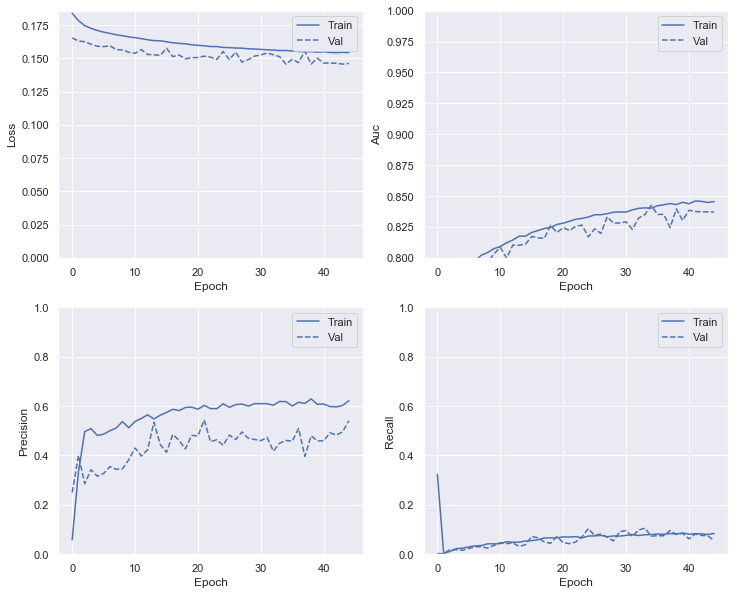

In [35]:
plot_metrics(baseline_history)

- Evaluating the **down-sampled 05/95** model using the **down-sampled 05/95** test dataset.

In [36]:
test_loss_ds_0595, test_tp_0595, test_fp_0595, test_tn_0595, test_fn_0595, test_accuracy_ds_0595, test_precision_0595, test_recall_0595, test_auc_0595 = model.evaluate(test_inputs_ds_0595, test_targets_ds_0595)

501/501 [==============================] - 1s 1ms/step - loss: 0.1581 - tp: 66.0000 - fp: 50.0000 - tn: 15135.0000 - fn: 751.0000 - accuracy: 0.9499 - precision: 0.5690 - recall: 0.0808 - auc: 0.8410


- Predicting classes of **down-sampled 05/95** model using the **down-sampled 05/95** test dataset.

In [37]:
y_pred = model.predict_classes(test_inputs_ds_0595)

- Predicting probabilities of **down-sampled 05/95** model using the **down-sampled 05/95** test dataset.

In [38]:
y_prob = model.predict(test_inputs_ds_0595)

- Uniting all results of **down-sampled 05/95** model using **down-sampled 05/95** test dataset into one dataframe.

In [39]:
# Targets of down-sampled 05/95 dataset
targets = pd.DataFrame(test_targets_ds_0595, columns=['target'])

# Predicted classes of down-sampled 05/95 dataset
y_pred = pd.DataFrame(y_pred, columns=['y_pred'])

# Predicted probabilities for each classe of down-sampled 05/95 dataset
y_prob = pd.DataFrame(y_prob, columns=['y_prob'])

# Uniting targets, predicted values and probabilities into a single data frame
results_ds_0595_1 = pd.concat([targets,y_pred,y_prob], axis=1)

- Evaluating the **down-sampled 05/95** model using the **test for all** dataset.

In [40]:
test_loss_ds_0595_tfa, test_tp_0595_tfa, test_fp_0595_tfa, test_tn_0595_tfa, test_fn_0595_tfa, test_accuracy_ds_0595_tfa, test_precision_0595_tfa, test_recall_0595_tfa, test_auc_0595_tfa = model.evaluate(test_inputs_tfa, test_targets_tfa)

3277/3277 [==============================] - 6s 2ms/step - loss: 0.0583 - tp: 63.0000 - fp: 337.0000 - tn: 103622.0000 - fn: 836.0000 - accuracy: 0.9888 - precision: 0.1575 - recall: 0.0701 - auc: 0.8409


- Predicting classes of **down-sampled 05/95** model using the **test for all** dataset.

In [41]:
y_pred = model.predict_classes(test_inputs_tfa)

- Predicting probabilities of **down-sampled 05/95** model using the **test for all** dataset.

In [42]:
y_prob = model.predict(test_inputs_tfa)

- Uniting all results of **down-sampled 05/95** model using **test for all** dataset into one dataframe.

In [43]:
# Targets of test for all dataset
targets = pd.DataFrame(test_targets_tfa, columns=['target'])

# Predicted classes of test for all dataset
y_pred = pd.DataFrame(y_pred, columns=['y_pred'])

# Predicted probabilities for each class of test for all dataset
y_prob = pd.DataFrame(y_prob, columns=['y_prob'])

# Uniting targets, predicted values and probabilities into a single data frame
results_ds_0595_2 = pd.concat([targets,y_pred,y_prob], axis=1)

- Validating results of **down-sampled 05/95** **tensorflow** model with **sklearn** metrics.

In [44]:
# Importing metrics library
from sklearn.metrics import accuracy_score

In [45]:
# Down-sampled 05/95 test dataset
accuracy_score(results_ds_0595_1['y_pred'],results_ds_0595_1['target'])

0.9499437570303711

In [46]:
# Test for all dataset
accuracy_score(results_ds_0595_2['y_pred'],results_ds_0595_2['target'])

0.9888134429418833

- Training the model using the **up-sampled** dataset.

In [47]:
model = make_model()
baseline_history = model.fit(
    train_inputs_us,  # train inputs
    train_targets_us, # train targets
    # batch_size=BATCH_SIZE, # batch size
    epochs=EPOCHS,         # epochs that we will train for (assuming early stopping doesn't kick in)
    callbacks = [early_stopping],  # early stopping
    validation_data=(validation_inputs_us, validation_targets_us) # validation data
)

Epoch 1/150
2000/2000 [==============================] - 6s 3ms/step - loss: 0.6140 - tp: 21570.0000 - fp: 10795.0000 - tn: 125263.0000 - fn: 11230.0000 - accuracy: 0.8696 - precision: 0.6665 - recall: 0.6576 - auc: 0.9261 - val_loss: 0.5827 - val_tp: 2757.0000 - val_fp: 1133.0000 - val_tn: 2817.0000 - val_fn: 1293.0000 - val_accuracy: 0.6967 - val_precision: 0.7087 - val_recall: 0.6807 - val_auc: 0.7647
Epoch 2/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.5772 - tp: 21871.0000 - fp: 8826.0000 - tn: 23273.0000 - fn: 10030.0000 - accuracy: 0.7054 - precision: 0.7125 - recall: 0.6856 - auc: 0.7701 - val_loss: 0.5686 - val_tp: 2970.0000 - val_fp: 1198.0000 - val_tn: 2752.0000 - val_fn: 1080.0000 - val_accuracy: 0.7153 - val_precision: 0.7126 - val_recall: 0.7333 - val_auc: 0.7833
Epoch 3/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5618 - tp: 22102.0000 - fp: 8143.0000 - tn: 23956.0000 - fn: 9799.0000 - accuracy: 0.7197 - precision: 0.73

Epoch 21/150
2000/2000 [==============================] - 6s 3ms/step - loss: 0.5011 - tp: 24376.0000 - fp: 7374.0000 - tn: 24725.0000 - fn: 7525.0000 - accuracy: 0.7672 - precision: 0.7677 - recall: 0.7641 - auc: 0.8375 - val_loss: 0.5020 - val_tp: 3035.0000 - val_fp: 836.0000 - val_tn: 3114.0000 - val_fn: 1015.0000 - val_accuracy: 0.7686 - val_precision: 0.7840 - val_recall: 0.7494 - val_auc: 0.8358
Epoch 22/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.5000 - tp: 24370.0000 - fp: 7282.0000 - tn: 24817.0000 - fn: 7531.0000 - accuracy: 0.7685 - precision: 0.7699 - recall: 0.7639 - auc: 0.8380 - val_loss: 0.5036 - val_tp: 3039.0000 - val_fp: 893.0000 - val_tn: 3057.0000 - val_fn: 1011.0000 - val_accuracy: 0.7620 - val_precision: 0.7729 - val_recall: 0.7504 - val_auc: 0.8354
Epoch 23/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4989 - tp: 24467.0000 - fp: 7341.0000 - tn: 24758.0000 - fn: 7434.0000 - accuracy: 0.7691 - precision: 0.7692 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.4765 - tp: 24853.0000 - fp: 6903.0000 - tn: 25196.0000 - fn: 7048.0000 - accuracy: 0.7820 - precision: 0.7826 - recall: 0.7791 - auc: 0.8536 - val_loss: 0.4821 - val_tp: 3268.0000 - val_fp: 985.0000 - val_tn: 2965.0000 - val_fn: 782.0000 - val_accuracy: 0.7791 - val_precision: 0.7684 - val_recall: 0.8069 - val_auc: 0.8500
Epoch 42/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4767 - tp: 24887.0000 - fp: 6983.0000 - tn: 25116.0000 - fn: 7014.0000 - accuracy: 0.7813 - precision: 0.7809 - recall: 0.7801 - auc: 0.8536 - val_loss: 0.4826 - val_tp: 2994.0000 - val_fp: 741.0000 - val_tn: 3209.0000 - val_fn: 1056.0000 - val_accuracy: 0.7754 - val_precision: 0.8016 - val_recall: 0.7393 - val_auc: 0.8516
Epoch 43/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4742 - tp: 24797.0000 - fp: 6848.0000 - tn: 25251.0000 - fn: 7104.0000 - accuracy: 0.7820 - precision: 0.7836 - recall: 0.77

2000/2000 [==============================] - 5s 3ms/step - loss: 0.4559 - tp: 25314.0000 - fp: 6623.0000 - tn: 25476.0000 - fn: 6587.0000 - accuracy: 0.7936 - precision: 0.7926 - recall: 0.7935 - auc: 0.8674 - val_loss: 0.4557 - val_tp: 3188.0000 - val_fp: 803.0000 - val_tn: 3147.0000 - val_fn: 862.0000 - val_accuracy: 0.7919 - val_precision: 0.7988 - val_recall: 0.7872 - val_auc: 0.8671
Epoch 62/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.4548 - tp: 25351.0000 - fp: 6599.0000 - tn: 25500.0000 - fn: 6550.0000 - accuracy: 0.7945 - precision: 0.7935 - recall: 0.7947 - auc: 0.8683 - val_loss: 0.4691 - val_tp: 3051.0000 - val_fp: 745.0000 - val_tn: 3205.0000 - val_fn: 999.0000 - val_accuracy: 0.7820 - val_precision: 0.8037 - val_recall: 0.7533 - val_auc: 0.8634
Epoch 63/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.4549 - tp: 25364.0000 - fp: 6645.0000 - tn: 25454.0000 - fn: 6537.0000 - accuracy: 0.7940 - precision: 0.7924 - recall: 0.795

2000/2000 [==============================] - 5s 2ms/step - loss: 0.4426 - tp: 25768.0000 - fp: 6581.0000 - tn: 25518.0000 - fn: 6133.0000 - accuracy: 0.8013 - precision: 0.7966 - recall: 0.8077 - auc: 0.8758 - val_loss: 0.4595 - val_tp: 3265.0000 - val_fp: 859.0000 - val_tn: 3091.0000 - val_fn: 785.0000 - val_accuracy: 0.7945 - val_precision: 0.7917 - val_recall: 0.8062 - val_auc: 0.8693
Epoch 82/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.4414 - tp: 25813.0000 - fp: 6515.0000 - tn: 25584.0000 - fn: 6088.0000 - accuracy: 0.8031 - precision: 0.7985 - recall: 0.8092 - auc: 0.8763 - val_loss: 0.4461 - val_tp: 3299.0000 - val_fp: 802.0000 - val_tn: 3148.0000 - val_fn: 751.0000 - val_accuracy: 0.8059 - val_precision: 0.8044 - val_recall: 0.8146 - val_auc: 0.8746
Epoch 83/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.4424 - tp: 25857.0000 - fp: 6539.0000 - tn: 25560.0000 - fn: 6044.0000 - accuracy: 0.8034 - precision: 0.7982 - recall: 0.810

- Checking training history

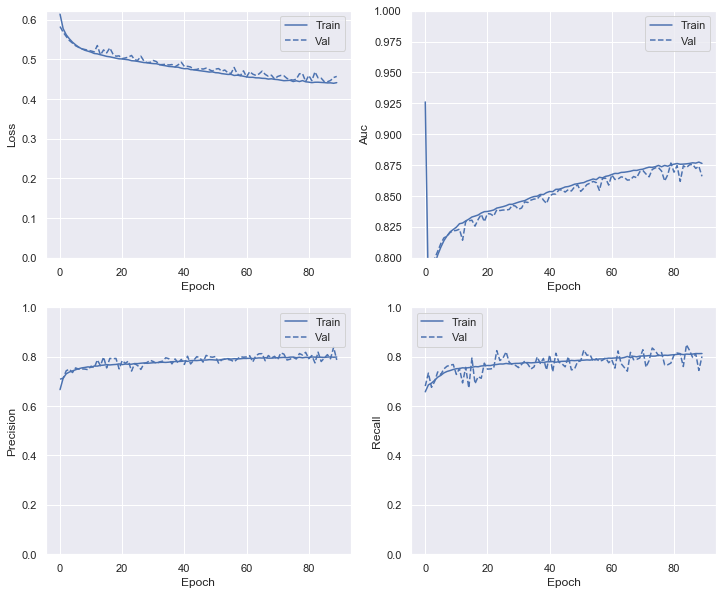

In [48]:
plot_metrics(baseline_history)

- Evaluating the **up-sampled** model using the **up-sampled** test dataset.

In [49]:
test_loss_us, test_tp_us, test_fp_us, test_tn_us, test_fn_us, test_accuracy_us, test_precision_us, test_recall_us, test_auc_us = model.evaluate(test_inputs_us, test_targets_us)

250/250 [==============================] - 1s 2ms/step - loss: 0.4488 - tp: 3133.0000 - fp: 714.0000 - tn: 3237.0000 - fn: 916.0000 - accuracy: 0.7962 - precision: 0.8144 - recall: 0.7738 - auc: 0.8747


- Predicting classes of **up-sampled** model using the **up-sampled** test dataset.

In [50]:
y_pred = model.predict_classes(test_inputs_us)

- Predicting probabilities of **up-sampled** model using the **up-sampled** test dataset.

In [51]:
y_prob = model.predict(test_inputs_us)

- Uniting all results of **up-sampled** model using **up-sampled** test dataset into one dataframe.

In [52]:
# Targets of up-sampled dataset
targets = pd.DataFrame(test_targets_us, columns=['target'])

# Predicted classes of up-sampled dataset
y_pred = pd.DataFrame(y_pred, columns=['y_pred'])

# Predicted probabilities for each classe of up-sampled dataset
y_prob = pd.DataFrame(y_prob, columns=['y_prob'])

# Uniting targets, predicted values and probabilities into a single data frame
results_us_1 = pd.concat([targets,y_pred,y_prob], axis=1)

- Evaluating the **up-sampled** model using **test for all** dataset.

In [53]:
test_loss_us_tfa, test_tp_us_tfa, test_fp_us_tfa, test_tn_us_tfa, test_fn_us_tfa, test_accuracy_us_tfa, test_precision_us_tfa, test_recall_us_tfa, test_auc_us_tfa = model.evaluate(test_inputs_tfa, test_targets_tfa)

3277/3277 [==============================] - 7s 2ms/step - loss: 1.8532 - tp: 883.0000 - fp: 91710.0000 - tn: 12249.0000 - fn: 16.0000 - accuracy: 0.1252 - precision: 0.0095 - recall: 0.9822 - auc: 0.7153


- Predicting classes with **up-sampled** model using the **test for all** dataset.

In [54]:
y_pred = model.predict_classes(test_inputs_tfa)

- Predicting probabilities of **up-sampled** model using the **test for all** dataset.

In [55]:
y_prob = model.predict(test_inputs_tfa)

- Combining all results of **up-sampled** model using **test for all** dataset into one dataframe.

In [56]:
# Targets of test for all dataset
targets = pd.DataFrame(test_targets_tfa, columns=['target'])

# Predicted classes of test for all dataset
y_pred = pd.DataFrame(y_pred, columns=['y_pred'])

# Predicted probabilities for each class of test for all dataset
y_prob = pd.DataFrame(y_prob, columns=['y_prob'])

# Uniting targets, predicted values and probabilities into a single data frame
results_us_2 = pd.concat([targets,y_pred,y_prob], axis=1)

- Validating results of **up-sampled** **tensorflow** model with **sklearn** metrics.

In [57]:
# Importing metrics library
from sklearn.metrics import accuracy_score

In [58]:
# Up-sampled test dataset
accuracy_score(results_us_1['y_pred'],results_us_1['target'])

0.79625

In [59]:
# Test for all dataset
accuracy_score(results_us_2['y_pred'],results_us_2['target'])

0.12523603349291423

## 5. Results

### 5.1. Accuracy and Loss metrics

- Creating a single dataframe with **accuracy** and **loss** results for all trained models (**Down-sampled 50/50**, **Down-sampled 05/95** and **Up-Sampled**) using its **single test** dataset.

In [60]:
# Defining Dataframe
df_loss_accuracy_1 = pd.DataFrame()

# Including trained model names
df_loss_accuracy_1['Model'] = pd.Series(['Down-sampled 50/50','Down-sampled 05/95','Up-Sampled'])

# Adding accuracy results for each model using its single test dataset
df_loss_accuracy_1['Accuracy'] = pd.Series([test_accuracy_ds_5050,test_accuracy_ds_0595,test_accuracy_us])

# Adding loss results for each model using its single test dataset
df_loss_accuracy_1['Loss'] = pd.Series([test_loss_ds_5050,test_loss_ds_0595,test_loss_us])

- Creating a single dataframe with **accuracy** an **loss** results for all trained models (**Down-sampled 50/50**, **Down-sampled 20/80** and **Up-Sampled**) using the **test for all** dataset.

In [61]:
# Defining Dataframe
df_loss_accuracy_2 = pd.DataFrame()

# Including trained model names
df_loss_accuracy_2['Model'] = pd.Series(['Down-sampled 50/50','Down-sampled 05/95','Up-Sampled'])

# Adding accuracy results for each model using test for all dataset
df_loss_accuracy_2['Accuracy'] = pd.Series([test_accuracy_ds_5050_tfa,test_accuracy_ds_0595_tfa,test_accuracy_us_tfa])

# Adding loss results for each model using test for all dataset
df_loss_accuracy_2['Loss'] = pd.Series([test_loss_ds_5050_tfa,test_loss_ds_0595_tfa,test_loss_us_tfa])

- Plotting Accuracy and Loss results using **single test** and **test for all** datasets

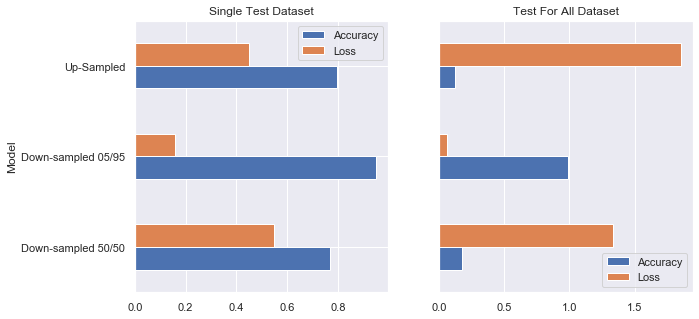

In [62]:
# Defining the figure of the plot and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,5))

# Plotting
df_loss_accuracy_1.plot(y=['Accuracy','Loss'], x='Model', kind ='barh', ax=ax1)
df_loss_accuracy_2.plot(y=['Accuracy','Loss'], x='Model', kind ='barh', ax=ax2)

# Defining plot parameters
ax1.set_title('Single Test Dataset', fontsize=12)
ax2.set_title('Test For All Dataset', fontsize=12)
ax2.yaxis.set_visible(False)

# Saving the plot
fig.savefig(path_figures + 'result_accuracy_loss.png', bbox_inches='tight')

plt.show()

### 5.2. ROC Curve (AUC)

- Importing the libraries to calculate the **ROC** and **AUC** metrics.

In [63]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### 5.2.1 Single Test Datasets

- Defining **X** and **Y** axies values to plot **ROC** and **AUC** metrics using the **single test** dataset of each dataset (**Down-sampled 50/50**, **Down-sampled 20/80** and **Up-Sampled**).

In [64]:
# Defining value parameters

# Defining No-Skill line
ns_probs_1 = [0 for _ in range(len(results_ds_5050_1['target']))] # no skill
ns_probs_2 = [0 for _ in range(len(results_ds_0595_1['target']))] # no skill
ns_probs_3 = [0 for _ in range(len(results_us_1['target']))] # no skill

# Probabilities values using single test dataset
probs_1 = results_ds_5050_1['y_prob'] # Down-sampled 50/50 single test dataset
probs_2 = results_ds_0595_1['y_prob'] # Down-sampled 05/95 single test dataset
probs_3 = results_us_1['y_prob'] # Up-sampled single test dataset

# Calculating AUC Score for No-Skill
ns_auc_1 = roc_auc_score(results_ds_5050_1['target'], ns_probs_1) # Down-sampled 50/50 single test dataset
ns_auc_2 = roc_auc_score(results_ds_0595_1['target'], ns_probs_2) # Down-sampled 05/95 single test dataset
ns_auc_3 = roc_auc_score(results_us_1['target'], ns_probs_3) # Up-sampled single test dataset

# Calculating AUC Score for each test dataset
auc_1 = roc_auc_score(results_ds_5050_1['target'], probs_1) # Down-sampled 50/50 single test dataset
auc_2 = roc_auc_score(results_ds_0595_1['target'], probs_2) # Down-sampled 05/95 single test dataset
auc_3 = roc_auc_score(results_us_1['target'], probs_3) # Up-sampled single test dataset

# Defining No Skill line for each plot
ns_tfp_1, ns_tvp_1, _ = roc_curve(results_ds_5050_1['target'], ns_probs_1) # Down-sampled 50/50 single test dataset
ns_tfp_2, ns_tvp_1, _ = roc_curve(results_ds_0595_1['target'], ns_probs_2) # Down-sampled 05/95 single test dataset
ns_tfp_3, ns_tvp_1, _ = roc_curve(results_us_1['target'], ns_probs_3) # Up-sampled single test dataset

# Defining single test dataset lines
tfp_1, tvp_1, _ = roc_curve(results_ds_5050_1['target'], probs_1) # Down-sampled 50/50 single test dataset
tfp_2, tvp_2, _ = roc_curve(results_ds_0595_1['target'], probs_2) # Down-sampled 05/95 single test dataset
tfp_3, tvp_3, _ = roc_curve(results_us_1['target'], probs_3) # Up-sampled single test dataset


- Plotting the **ROC** and **AUC** metrics using the **single test** dataset of each dataset (**Down-sampled 50/50**, **Down-sampled 20/80** and **Up-Sampled**).

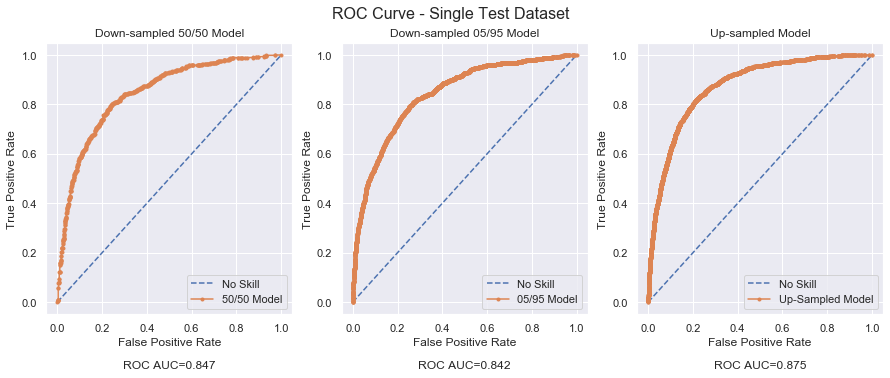

In [65]:
# Defining size of figure and quantity of plots
fig, (ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Figure parameters
fig.suptitle('ROC Curve - Single Test Dataset', fontsize=16)

# Down-sampled 50/50 Model Plot
# Axis parameters
ax3.set_title('Down-sampled 50/50 Model')
ax3.set_ylabel('True Positive Rate')
ax3.set_xlabel('False Positive Rate')
# Plotting
ax3.plot(ns_tfp_1, ns_tvp_1, linestyle='--', label='No Skill')
ax3.plot(tfp_1, tvp_1, marker='.', label='50/50 Model')
# AUC Result
ax3.text(0.5,-0.2,'ROC AUC=%.3f' %(auc_1), size=12, ha="center", 
         transform=ax3.transAxes)
ax3.legend(loc = 'lower right')

# Down-sampled 05/95 Model Plot
# Axis parameters
ax4.set_title('Down-sampled 05/95 Model')
ax4.set_ylabel('True Positive Rate')
ax4.set_xlabel('False Positive Rate')
# Plotting
ax4.plot(ns_tfp_2, ns_tvp_1, linestyle='--', label='No Skill')
ax4.plot(tfp_2, tvp_2, marker='.', label='05/95 Model')
# AUC Result
ax4.text(0.5,-0.2,'ROC AUC=%.3f' %(auc_2), size=12, ha="center", 
         transform=ax4.transAxes)
ax4.legend(loc = 'lower right')

# Up-sampled Model Plot
# Axis Parameters
ax5.set_title('Up-sampled Model')
ax5.set_ylabel('True Positive Rate')
ax5.set_xlabel('False Positive Rate')
# Plotting
ax5.plot(ns_tfp_3, ns_tvp_1, linestyle='--', label='No Skill')
ax5.plot(tfp_3, tvp_3, marker='.', label='Up-Sampled Model')
# AUC Result
ax5.text(0.5,-0.2,'ROC AUC=%.3f' %(auc_3), size=12, ha="center", 
         transform=ax5.transAxes)
ax5.legend(loc = 'lower right')

# Saving the plot
plt.savefig(path_figures + 'roc_curve_single_test.png', bbox_inches='tight')

plt.show()

### 5.2.2 Test For All Dataset

- Defining **X** and **Y** axies values to plot **ROC** and **AUC** metrics using the **test for all** dataset.

In [66]:
# Defining value parameters

# Defining No-Skill line
ns_probs_1 = [0 for _ in range(len(results_ds_5050_2['target']))] # no skill
ns_probs_2 = [0 for _ in range(len(results_ds_0595_2['target']))] # no skill
ns_probs_3 = [0 for _ in range(len(results_us_2['target']))] # no skill

# Probabilities values using single test dataset
probs_1 = results_ds_5050_2['y_prob'] # Test for all dataset using Down-sampled 50/50 trained model
probs_2 = results_ds_0595_2['y_prob'] # Test for all dataset using Down-sampled 05/95 trained model
probs_3 = results_us_2['y_prob'] # Test for all dataset using Up-sampled trained model

# Calculating AUC Score for No-Skill
ns_auc_1 = roc_auc_score(results_ds_5050_2['target'], ns_probs_1) # Test for all dataset using Down-sampled 50/50 trained model
ns_auc_2 = roc_auc_score(results_ds_0595_2['target'], ns_probs_2) # Test for all dataset using Down-sampled 05/95 trained model
ns_auc_3 = roc_auc_score(results_us_2['target'], ns_probs_3) # Test for all dataset using Up-sampled trained model

# Calculating AUC Score for each test dataset
auc_1 = roc_auc_score(results_ds_5050_2['target'], probs_1) # Test for all dataset using Down-sampled 50/50 trained model
auc_2 = roc_auc_score(results_ds_0595_2['target'], probs_2) # Test for all dataset using Down-sampled 05/95 trained model
auc_3 = roc_auc_score(results_us_2['target'], probs_3) # Test for all dataset using Up-sampled trained model

# Defining No Skill line for each plot
ns_tfp_1, ns_tvp_1, _ = roc_curve(results_ds_5050_2['target'], ns_probs_1) # Test for all dataset using Down-sampled 50/50 trained model
ns_tfp_2, ns_tvp_1, _ = roc_curve(results_ds_0595_2['target'], ns_probs_2) # Test for all dataset using Down-sampled 05/95 trained model
ns_tfp_3, ns_tvp_1, _ = roc_curve(results_us_2['target'], ns_probs_3) # Test for all dataset using Up-sampled trained model

# Defining single test dataset lines
tfp_1, tvp_1, _ = roc_curve(results_ds_5050_2['target'], probs_1) # Test for all dataset using Down-sampled 50/50 trained model
tfp_2, tvp_2, _ = roc_curve(results_ds_0595_2['target'], probs_2) # Test for all dataset using Down-sampled 05/95 trained model
tfp_3, tvp_3, _ = roc_curve(results_us_2['target'], probs_3) # Test for all dataset using Up-sampled trained model


- Plotting the **ROC** and **AUC** metrics using the **test for all** dataset.

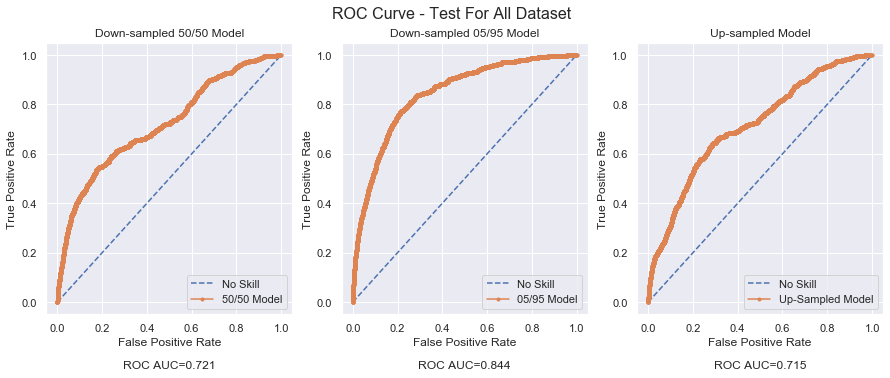

In [67]:
# Defining size of figure and quantity of plots
fig, (ax6, ax7, ax8) = plt.subplots(nrows=1, ncols=3, figsize=(15,5)) #constrained_layout=True)

# Figure parameters
fig.suptitle('ROC Curve - Test For All Dataset', fontsize=16)

# Down-sampled 50/50 Model Plot
# Axis parameters
ax6.set_title('Down-sampled 50/50 Model')
ax6.set_ylabel('True Positive Rate')
ax6.set_xlabel('False Positive Rate')
# Plotting
ax6.plot(ns_tfp_1, ns_tvp_1, linestyle='--', label='No Skill')
ax6.plot(tfp_1, tvp_1, marker='.', label='50/50 Model')
# AUC Result
ax6.text(0.5,-0.2,'ROC AUC=%.3f' %(auc_1), size=12, ha="center", 
         transform=ax6.transAxes)
ax6.legend(loc = 'lower right')

# Down-sampled 20/80 Model Plot
# Axis parameters
ax7.set_title('Down-sampled 05/95 Model')
ax7.set_ylabel('True Positive Rate')
ax7.set_xlabel('False Positive Rate')
# Plotting
ax7.plot(ns_tfp_2, ns_tvp_1, linestyle='--', label='No Skill')
ax7.plot(tfp_2, tvp_2, marker='.', label='05/95 Model')
# AUC Result
ax7.text(0.5,-0.2,'ROC AUC=%.3f' %(auc_2), size=12, ha="center", 
         transform=ax7.transAxes)
ax7.legend(loc = 'lower right')

# Up-sampled Model Plot
# Axis parameters
ax8.set_title('Up-sampled Model')
ax8.set_ylabel('True Positive Rate')
ax8.set_xlabel('False Positive Rate')
# Plotting
ax8.plot(ns_tfp_3, ns_tvp_1, linestyle='--', label='No Skill')
ax8.plot(tfp_3, tvp_3, marker='.', label='Up-Sampled Model')
# AUC Result
ax8.text(0.5,-0.2,'ROC AUC=%.3f' %(auc_3), size=12, ha="center", 
         transform=ax8.transAxes)
ax8.legend(loc = 'lower right')

# Saving the plot
plt.savefig(path_figures + 'roc_curve_all_test.png', bbox_inches='tight')

plt.show()

### 6.3. Precision, Recall, Accuracy and F1 Scores

- Importing the necessary libraries to calculate **Precision**, **Recall**, **Accuracy** and **F1 Scores**.

In [68]:
from sklearn.metrics import (recall_score,
                             accuracy_score,
                             precision_score,
                             f1_score)

- Calculating **Precision** score based on the target and predicted values of both test datasets (**Single test** and **Test for all** dataset).

\begin{equation}
Precision = \frac{True Positives}{True Positives + False Positives}
\end{equation}

In [69]:
# Precision

# Single test dataset
p_score_1 = precision_score(results_ds_5050_1['target'],results_ds_5050_1['y_pred']) # Down-sampled 50/50 single test dataset
p_score_2 = precision_score(results_ds_0595_1['target'],results_ds_0595_1['y_pred']) # Down-sampled 05/95 single test dataset
p_score_3 = precision_score(results_us_1['target'],results_us_1['y_pred']) # Up-sampled single test dataset

# Test for all dataset
p_score_4 = precision_score(results_ds_5050_2['target'],results_ds_5050_2['y_pred']) # Test for all dataset using 50/50 model
p_score_5 = precision_score(results_ds_0595_2['target'],results_ds_0595_2['y_pred']) # Test for all dataset using 05/95 model
p_score_6 = precision_score(results_us_2['target'],results_us_2['y_pred']) # Test for all dataset using Up-sampled model

- Calculating **Recall** score based on the target and predicted values of both test datasets (**Single test** and **Test for all** dataset).

\begin{equation}
Recall = \frac{True Positives}{True Positives + False Negatives}
\end{equation}

In [70]:
# Recall

# Single test dataset
r_score_1 = recall_score(results_ds_5050_1['target'],results_ds_5050_1['y_pred']) # Down-sampled 50/50 single test dataset
r_score_2 = recall_score(results_ds_0595_1['target'],results_ds_0595_1['y_pred']) # Down-sampled 05/95 single test dataset
r_score_3 = recall_score(results_us_1['target'],results_us_1['y_pred']) # Up-sampled single test dataset

# Test for all dataset
r_score_4 = recall_score(results_ds_5050_2['target'],results_ds_5050_2['y_pred']) # Test for all dataset using 50/50 model
r_score_5 = recall_score(results_ds_0595_2['target'],results_ds_0595_2['y_pred']) # Test for all dataset using 05/95 model
r_score_6 = recall_score(results_us_2['target'],results_us_2['y_pred']) # Test for all dataset using Up-sampled model

- Calculating **Accuracy** score based on the target and predicted values of both test datasets (**Single test** and **Test for all** dataset).

\begin{equation}
Accuracy = \frac{ True Positives + True Negatives}{ True Positives + False Positives + True Negatives + False Negatives}
\end{equation}

In [71]:
# Accuracy

# Single test dataset (Already collected when validating the results)
a_score_1 = test_accuracy_ds_5050 # Down-sampled 50/50 single test dataset 
a_score_2 = test_accuracy_ds_0595 # Down-sampled 05/95 single test dataset 
a_score_3 = test_accuracy_us # Up-sampled single test dataset 

# Test for all dataset (Already collected when validating the results)
a_score_4 = test_accuracy_ds_5050_tfa # Test for all dataset using 50/50 model
a_score_5 = test_accuracy_ds_0595_tfa # Test for all dataset using 05/95 model
a_score_6 = test_accuracy_us_tfa # Test for all dataset using Up-sampled model

- Calculating **F1** score based on the target and predicted values of bothe test datasets (**Single Test** and **Test for all** dataset).

\begin{equation}
F1 = 2 \cdot \frac{ Precision\cdot Recall}{Precision + Recall}
\end{equation}

In [72]:
# F1 Score

# Single test dataset
f_score_1 = f1_score(results_ds_5050_1['target'],results_ds_5050_1['y_pred']) # Down-sampled 50/50 single test dataset
f_score_2 = f1_score(results_ds_0595_1['target'],results_ds_0595_1['y_pred']) # Down-sampled 05/95 single test dataset
f_score_3 = f1_score(results_us_1['target'],results_us_1['y_pred']) # Up-sampled single test dataset

# Test for all dataset
f_score_4 = f1_score(results_ds_5050_2['target'],results_ds_5050_2['y_pred']) # Test for all dataset using 50/50 model
f_score_5 = f1_score(results_ds_0595_2['target'],results_ds_0595_2['y_pred']) # Test for all dataset using 05/95 model
f_score_6 = f1_score(results_us_2['target'],results_us_2['y_pred']) # Test for all dataset using Up-sampled model

- Uniting all results into one single dataframe.

In [73]:
score_results = {'Experiment':['Single Test Dataset', 'Single Test Dataset', 'Single Test Dataset', 
                           'Test For All Dataset', 'Test For All Dataset', 'Test For All Dataset'],
                 'Model':['Down-sampled 50/50','Down-sampled 05/95','Up-Sampled',
                            'Down-sampled 50/50','Down-sampled 05/95','Up-Sampled'],
                     'Precision':[p_score_1, p_score_2, p_score_3,
                                  p_score_4, p_score_5, p_score_6],
                     'Recall': [r_score_1, r_score_2, r_score_3,
                                r_score_4, r_score_5, r_score_6],
                     'Accuracy': [a_score_1, a_score_2, a_score_3,
                                  a_score_4, a_score_5, a_score_6],
                     'F1_score': [f_score_1, f_score_2, f_score_3,
                                  f_score_4, f_score_5, f_score_6]}

In [74]:
df_score_results = pd.DataFrame(score_results)

In [75]:
df_score_results

,Experiment,Model,Precision,Recall,Accuracy,F1_score
0,Single Test Dataset,Down-sampled 50/50,0.780899,0.722078,0.768894,0.750337
1,Single Test Dataset,Down-sampled 05/95,0.568966,0.080783,0.949944,0.141479
2,Single Test Dataset,Up-Sampled,0.814401,0.773771,0.796250,0.793566
3,Test For All Dataset,Down-sampled 50/50,0.009952,0.967742,0.174341,0.019702
4,Test For All Dataset,Down-sampled 05/95,0.157500,0.070078,0.988813,0.096998
5,Test For All Dataset,Up-Sampled,0.009536,0.982202,0.125236,0.018889


### 7.4. Confusion Matrix

### 7.4.1 Single Test Datasets

- Importing the necessary library to plot **confusion matrix**.

In [76]:
from sklearn.metrics import confusion_matrix

- Plotting the **Confusion Matrix** using the **single test** dataset of each dataset (**Down-sampled 50/50**, **Down-sampled 20/80** and **Up-Sampled**).

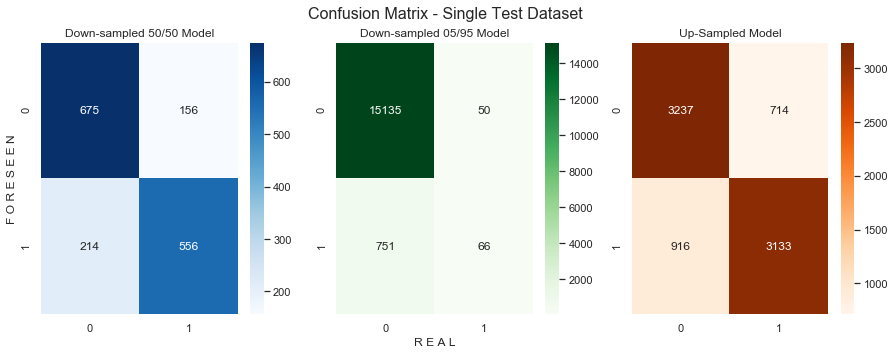

In [77]:
# Defining size of figure and quantity of plots
fig, (ax9, ax10, ax11) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Figure parameters
fig.suptitle('Confusion Matrix - Single Test Dataset', fontsize=16)
# fig.set_figheight(5)
# fig.set_figwidth(10)

# Down-sampled 50/50 Model Plot
# Plotting
sns.heatmap(confusion_matrix(results_ds_5050_1['target'],
                             results_ds_5050_1['y_pred']), cmap='Blues', annot=True, fmt='2.0f', ax=ax9)
# Axis parameters
ax9.set_title('Down-sampled 50/50 Model')
ax9.set_ylabel('F O R E S E E N')
# ax9.set_xlabel('R E A L')
# ax9.xaxis.set_visible(False)

# Down-sampled 05/95 Model
# Plotting
sns.heatmap(confusion_matrix(results_ds_0595_1['target'], 
                             results_ds_0595_1['y_pred']), cmap='Greens', annot=True, fmt='2.0f', ax=ax10)
# Axis parameters
ax10.set_title('Down-sampled 05/95 Model')
# ax10.set_ylabel('F O R E S E E N')
ax10.set_xlabel('R E A L')
# ax10.yaxis.set_visible(False)

# Up-Sampled Model
# Plotting
sns.heatmap(confusion_matrix(results_us_1['target'], 
                             results_us_1['y_pred']), cmap='Oranges', annot=True, fmt='2.0f', ax=ax11)
# Axis parameters
ax11.set_title('Up-Sampled Model')
# ax11.set_ylabel('F O R E S E E N')
# ax11.set_xlabel('R E A L')
# ax11.yaxis.set_visible(False)
# ax11.xaxis.set_visible(False)
                       
# Saving the plot
plt.savefig(path_figures + 'confusion_matrix_single.png', bbox_inches='tight')

plt.show()

### 7.4.2 Test For All Dataset

- Plotting the **Confusion Matrix** using the **test for all** dataset.

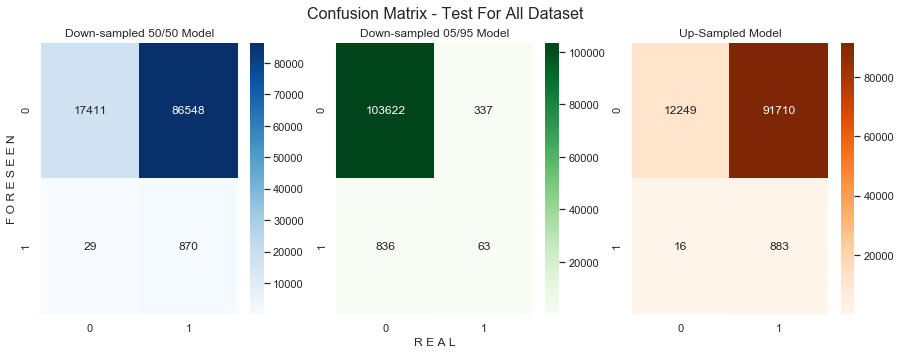

In [78]:
# Defining size of figure and quantity of plots
fig, (ax12, ax13, ax14) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Figure parameters
fig.suptitle('Confusion Matrix - Test For All Dataset', fontsize=16)

# Down-sampled 50/50 trained model
# Plotting
sns.heatmap(confusion_matrix(results_ds_5050_2['target'],
                             results_ds_5050_2['y_pred']), cmap='Blues', annot=True, fmt='2.0f', ax=ax12)
# Axis parameters
ax12.set_title('Down-sampled 50/50 Model')
ax12.set_ylabel('F O R E S E E N')
# ax12.set_xlabel('R E A L')

# Down-sampled 05/95 trained model
# Plotting
sns.heatmap(confusion_matrix(results_ds_0595_2['target'], 
                             results_ds_0595_2['y_pred']), cmap='Greens', annot=True, fmt='2.0f', ax=ax13)
# Axis parameters
ax13.set_title('Down-sampled 05/95 Model')
# ax13.set_ylabel('F O R E S E E N')
ax13.set_xlabel('R E A L')

# Up-sampled trained model
# Plotting
sns.heatmap(confusion_matrix(results_us_2['target'], 
                             results_us_2['y_pred']), cmap='Oranges', annot=True, fmt='2.0f', ax=ax14)
# Axis parameters
ax14.set_title('Up-Sampled Model')
# ax14.set_ylabel('F O R E S E E N')
# ax14.set_xlabel('R E A L')

# Saving the plots
plt.savefig(path_figures + 'confusion_matrix_all.png', bbox_inches='tight')

plt.show()